In [6]:
# 開始用 python 的 os.walk 讀取 ./train filename
import os
for root, dirs, files in os.walk("./train"):
    print(f'{len(files)} files in total.')
    for file in files[:3]:
        print(os.path.join(root, file).replace("\\", "/"))

21765 files in total.
./train/00000.jpg
./train/00001.jpg
./train/00002.jpg


Image shape (128, 128, 3)


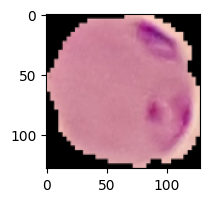

In [7]:
# 針對 ./train/filename.jpg 使用 matplotlib.pyplot 讀取該影像資料並顯示
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
f = './train/09881.jpg'
img = mpimg.imread(f)
print('Image shape', img.shape)
plt.figure(figsize = (2, 2))
plt.imshow(img)
plt.show()

In [10]:
# 讀取 ./train_labels.csv 中存在每一張對應 ./train/filename.jpg 的 infected 狀態
# 轉寫成是根據 filename.jpg 到 ./train_labels.csv
# 找出對應的 infected 數值
import pandas as pd
df = pd.read_csv('./train_labels.csv')
print(df.shape)
df[:4]

(21765, 2)


,filename,infected
0,00000.jpg,1
1,00001.jpg,1
2,00002.jpg,1
3,00003.jpg,0


In [12]:
# 根據檔案名稱找出對應 infected 數值
import re
print(re.split(r"/|\\", f)[-1])
df[ df['filename']==re.split(r"/|\\", f)[-1] ].infected.values[0]

09881.jpg


1

In [13]:
# All in one
import pandas as pd
df = pd.read_csv('./train_labels.csv')

import os
for root, dirs, files in os.walk("./train"):
    print(root.replace("\\", "/"))
    print(dirs)
    print(files[:4], "\n")
    for file in files[:10]:
        print(os.path.join(root, file).replace("\\", "/"), \
              df[ df['filename']==re.split(r"/|\\", os.path.join(root, file))[-1] ].infected.values[0])

./train
[]
['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg'] 

./train/00000.jpg 1
./train/00001.jpg 1
./train/00002.jpg 1
./train/00003.jpg 0
./train/00004.jpg 0
./train/00005.jpg 1
./train/00006.jpg 0
./train/00007.jpg 1
./train/00008.jpg 1
./train/00009.jpg 0


In [14]:
# 資料準備 X = 所有影像數據  預計 shape = (21765, 128, 128, 3)
# 資料準備 y = df.inftected 預計 shape = (21765, 1)
# All in one II
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
df = pd.read_csv('./train_labels.csv')
images = [] # 放影像資料
target = [] # 放影像對應感染狀況
for root, dirs, files in os.walk("./train"):
    for file in files[:10]:
        img = plt.imread(os.path.join(root, file).replace("\\", "/"))
        label = df[ df['filename']==file ].infected.values[0]

        images.append(img)
        target.append(label)

        print(os.path.join(root, file).replace("\\", "/"), label)

X, y = np.array(images), np.array(target)
print(X.shape, y.shape)
print(f"\n{X[0].min()}, {X[0].max()}") # 會顯示 0.0 1.0，之所以不是 0.0 255.0，蓋因影像本身已是 0.0 1.0

./train/00000.jpg 1
./train/00001.jpg 1
./train/00002.jpg 1
./train/00003.jpg 0
./train/00004.jpg 0
./train/00005.jpg 1
./train/00006.jpg 0
./train/00007.jpg 1
./train/00008.jpg 1
./train/00009.jpg 0
(10, 128, 128, 3) (10,)

0.0, 1.0


In [15]:
import numpy as np
from tqdm import tqdm

images = [] # 放影像資料
target = [] # 放影像對應感染狀況
for root, dirs, files in os.walk("./train"):
    for file in tqdm(files[:-1]):
        img = plt.imread(os.path.join(root, file).replace("\\", "/"))
        label = df[ df['filename']==file ].infected.values[0]

        images.append(img)
        target.append(label)

X, y = np.array(images), np.array(target)
print(X.shape, y.shape)

100%|██████████| 21764/21764 [00:32<00:00, 673.36it/s]


(21764, 128, 128, 3) (21764,)


In [16]:
# 類別樣本數是否失衡
#     sum(y)/len(y) # 1 (被感染) 的比例
# 1 - sum(y)/len(y) # 0 (健康) 的比例
sum(y)/len(y), 1 - sum(y)/len(y) # (0.495, 0.504) # 約 1:1.018 相當平衡

(0.4951755192060283, 0.5048244807939717)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=2018081517)

X_train[0].min(), X_train[0].max()

(0.0, 1.0)

In [20]:
# 確認一下
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15234, 128, 128, 3), (6530, 128, 128, 3), (15234,), (6530,))

In [25]:
# 使用 keras sequential 模型針對數據 X, y 進行 binary classification
# 其中 X shape 為 (21765, 128, 128, 3), y shape 為 (21765,)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # 等價於 tf.keras.Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.regularizers import L2
from tensorflow.keras.optimizers import Adam, SGD

# model = None
# 模型建構
pen = .0000005 # kernel regularizer penalty
ratio_SE = 2
ratio_CBAM = 2
kernel_size = 7
# input_shape = X_train.shape[1:] # (15234, 128, 128, 3) -> (128, 128, 3)
model = Sequential([
	# keras.Input(shape=input_shape),
	# 1st 捲積
	Conv2D(16, 3, activation='relu', input_shape=(128, 128, 3), kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 2nd 捲積
	Conv2D(16, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 3rd 捲積
	Conv2D(32, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 4th 捲積
	Conv2D(32, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 5th 捲積
	Conv2D(48, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	MaxPooling2D((2, 2)),
	# 6th 捲積
	# Conv2D(48, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	# MaxPooling2D((2, 2)),
	# 7th 捲積
	# Conv2D(48, 3, activation='relu', kernel_initializer='normal', kernel_regularizer=L2(pen), padding="same"),
	# MaxPooling2D((2, 2)),
	# 展開層
	# Flatten(),
	GlobalAveragePooling2D(), # 用全局平均池化層 GlobalAveragePooling2D 取代 Flatten
	Dropout(.5),
	BatchNormalization(),
	# 全連接層
	Dense(64, activation='relu', kernel_initializer='normal'),
	Dropout(.5),
	BatchNormalization(),
	# Dense(64, activation='relu', kernel_initializer='normal'),
	# Dropout(.5),
	# BatchNormalization(),
	# 輸出層 (二元分類)
	Dense(1, activation='sigmoid')
])

# 編譯模型
optimizer = Adam(learning_rate=.0001)
# optimizer = Adam(learning_rate=.00013, beta_1=.8, beta_2=.99, amsgrad=False)
result = model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=1000, restore_best_weights=True)
callbacks = [early_stopping]
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# callbacks = [early_stopping, ReduceLROnPlateau(patience=3, factor=.8, min_lr=1e-7)]

keras.backend.clear_session() # reset global state generated by TF-Keras / release VRAM
import gc; gc.collect()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0

##### <b>The following training is performed without <i style="color: #FF0; background: #000;">Data Augmentation</i>.<br/>If you want to apply <i style="color: #FF0; background: #000;">Data Augmentation</i> before training, skip this section and jump directly to the later <i style="color: #FF0; background: #000;">Data Augmentation</i> section, then start training.</b>

In [ ]:
# 模型訓練
epochs = 30
train_history = model.fit(X_train, y_train, validation_split=.2, epochs=epochs, batch_size=32,
							verbose=2, callbacks=callbacks)
print("Done！")

Epoch 1/30
381/381 - 7s - loss: 0.7048 - accuracy: 0.5371 - val_loss: 0.6920 - val_accuracy: 0.5087 - 7s/epoch - 18ms/step
Epoch 2/30
381/381 - 3s - loss: 0.6607 - accuracy: 0.6034 - val_loss: 0.6445 - val_accuracy: 0.6344 - 3s/epoch - 9ms/step
Epoch 3/30
381/381 - 3s - loss: 0.6097 - accuracy: 0.6749 - val_loss: 0.5320 - val_accuracy: 0.7804 - 3s/epoch - 9ms/step
Epoch 4/30
381/381 - 3s - loss: 0.3872 - accuracy: 0.8508 - val_loss: 0.2002 - val_accuracy: 0.9314 - 3s/epoch - 9ms/step
Epoch 5/30
381/381 - 3s - loss: 0.2242 - accuracy: 0.9292 - val_loss: 0.1788 - val_accuracy: 0.9334 - 3s/epoch - 9ms/step
Epoch 6/30
381/381 - 3s - loss: 0.2016 - accuracy: 0.9413 - val_loss: 0.1904 - val_accuracy: 0.9399 - 3s/epoch - 9ms/step
Epoch 7/30
381/381 - 3s - loss: 0.1965 - accuracy: 0.9408 - val_loss: 0.1627 - val_accuracy: 0.9485 - 3s/epoch - 8ms/step
Epoch 8/30
381/381 - 3s - loss: 0.1918 - accuracy: 0.9440 - val_loss: 0.1681 - val_accuracy: 0.9475 - 3s/epoch - 8ms/step
Epoch 9/30
381/381 - 3s

In [ ]:
# 模型評估
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy of testing data = {accuracy:.2%}")
print(f"Loss of testing data = {loss:.2%}")
model.save("./model_CNN_myADJ.keras")

205/205 [==============================] - 1s 5ms/step - loss: 0.1155 - accuracy: 0.9617
Accuracy of testing data = 96.17%
Loss of testing data = 11.55%


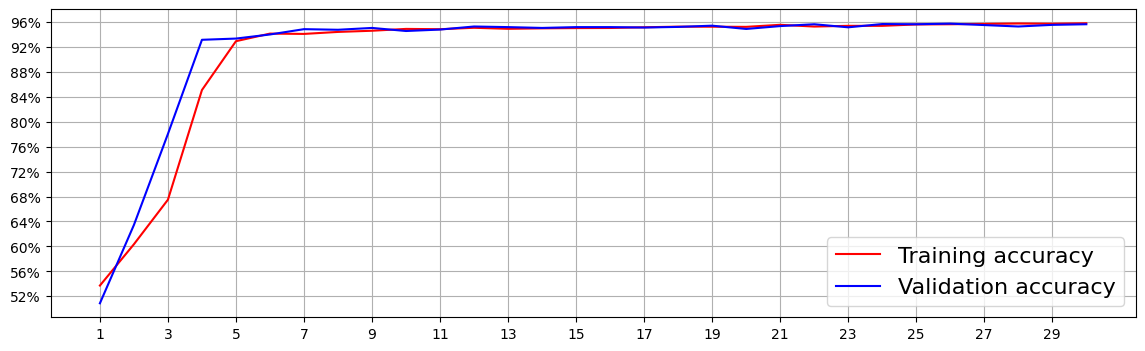

In [ ]:
# accuracy chart
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
x = np.arange(0, epochs, 2)
plt.xticks(ticks=x, labels=x+1)
y = np.arange(0, 1.05, .04)
plt.yticks(ticks=y, labels=[f"{tk:.0%}" for tk in y])
plt.plot(train_history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(train_history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()

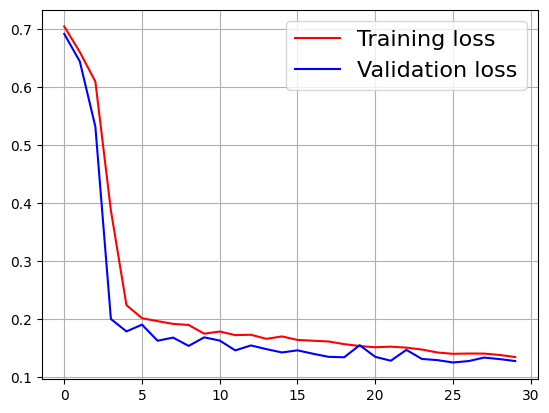

In [ ]:
# loss chart
import matplotlib.pyplot as plt
# plt.figure(figsize=(8, 6))
# y = np.arange(0, 1.05, .05)
# plt.yticks(ticks=y)
plt.plot(train_history.history['loss'], 'r', label='Training loss')
plt.plot(train_history.history['val_loss'], 'b', label='Validation loss')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()

./train/00002.jpg [1] <--- Real State


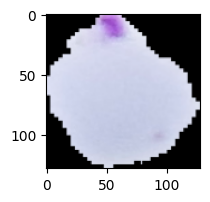

1/1 [==============================] - 0s 123ms/step
[0.96618927]
1/1 [==============================] - 0s 16ms/step
['Inflected']


In [ ]:
# 資料準備 X = 所有影像數據  預計 shape = (21765, 128, 128, 3)
# 資料準備 y = df.inftected 預計 shape = (21765, 1)
# All in one Final 進行預測
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import random
df = pd.read_csv('./train_labels.csv')
images = [] # 放影像資料
target = [] # 放影像對應感染狀況
for root, dirs, files in os.walk("./train"):
    files = files[-1:] + files[:5]
    for file in [ random.choice(files) ]:
        img = plt.imread(os.path.join(root, file).replace("\\", "/"))
        label = df[ df['filename']==file ].infected.values[0]

        images.append(img)
        target.append(label)

X_predict, y_fact = np.array(images), np.array(target)
print(os.path.join(root, file).replace("\\", "/"), y_fact, "<--- Real State")
plt.figure(figsize = (2, 2))
plt.imshow(X_predict[0].reshape(128, 128, 3))
plt.show()
print(model.predict(X_predict)[0])
print( np.where(model.predict(X_predict)[0] > 0.5, 'Inflected', 'Uninfected') )

In [26]:
import os; os.environ['NO_ALBUMENTATIONS_UPDATE'] = '1' # 去除 albumentations 的更新提示 UserWarning
# Data Augmentation
import albumentations as A
import cv2
transform = A.Compose([
    A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.5),
    # A.Affine(scale=(.8, 1.2), translate_percent=(-.1, .1), rotate=(-10, 10), shear=(-10, 10), interpolation=cv2.INTER_LINEAR, p=.5),
    A.Sequential([
        A.OneOf([
            A.Affine(scale=(.8, 1), interpolation=cv2.INTER_AREA, p=.75),
            A.Affine(scale=(1, 1.2), interpolation=cv2.INTER_LINEAR, p=.25),
        ], p=1),
        A.Affine(translate_percent=(-.1, .1), rotate=(-10, 10), shear=(-10, 10), interpolation=cv2.INTER_LINEAR, p=1),
    ], p=.5),
    A.ColorJitter(brightness=.1, contrast=.1, saturation=.2, hue=.5, p=.1),
    A.MedianBlur(blur_limit=(3, 3), p=.1),
    A.CLAHE(clip_limit=(1, 4), tile_grid_size=(8, 8), p=.5),
    A.GaussNoise(std_range=(.2, .44), mean_range=(0, 0), per_channel=True, p=.5),
    A.CoarseDropout(num_holes_range=(1, 1), hole_width_range=(.05, .1), hole_height_range=(.05, .1), p=.5),
    A.Normalize(normalization="min_max", p=1),
], seed=None, p=1.)

def augment(image, label):
    # Albumentations 接受 uint8 影像
    image_uint8 = tf.image.convert_image_dtype(image, tf.uint8)
    def _aug(img):
        return transform(image=img)['image']
    # aug_img = tf.numpy_function(_aug, [image_uint8], tf.uint8)
    aug_img = tf.numpy_function(_aug, [image_uint8], tf.float32) # A.Normalize 專用
    # 轉回 float32 並 normalize
    # aug_img = tf.image.convert_image_dtype(aug_img, tf.float32)
    aug_img.set_shape(image.shape)
    return aug_img, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
# train_ds = train_ds.shuffle(buffer_size=len(X_train), seed=2034581517).batch(32).prefetch(tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=2000, seed=2034581517).batch(32).prefetch(tf.data.AUTOTUNE)

X_val, X_test2, y_val, y_test2 = train_test_split(X_test, y_test, test_size=.33, stratify=y_test, random_state=2034581517)

# val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(buffer_size=len(X_val), seed=2034581517).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).shuffle(buffer_size=2000, seed=2034581517).batch(32).prefetch(tf.data.AUTOTUNE)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test2, y_test2)).shuffle(buffer_size=len(X_test2), seed=2034581517).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((X_test2, y_test2)).shuffle(buffer_size=2000, seed=2034581517).batch(32)

In [27]:
epochs = 550
model = keras.models.load_model('./model_CNN_myADJ.keras')

optimizer = Adam(learning_rate=.00013)
# optimizer = Adam(learning_rate=.00013, beta_1=.59, beta_2=.969, amsgrad=False, decay=.004, clipnorm=10.)
# optimizer = Adam(learning_rate=.00013, beta_1=.7, beta_2=.98, amsgrad=False)
result = model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=3000, restore_best_weights=True)
callbacks = [early_stopping]
# from tensorflow.keras.callbacks import ReduceLROnPlateau
# reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", patience=3, factor=.8, min_lr=1e-7)
# callbacks = [early_stopping, reduce_lr]

keras.backend.clear_session() # reset global state generated by TF-Keras / release VRAM
import gc; gc.collect()
train_history = model.fit(train_ds,
                          steps_per_epoch = len(X_train) // 32 + 1,
                          epochs = epochs,
                          validation_data = val_ds,
                          # validation_data = (X_val, y_val),
                          validation_steps = len(X_val) // 32 + 1,
                          verbose = 2, callbacks = callbacks)
print("Done！")

Epoch 1/550
477/477 - 22s - loss: 0.3033 - accuracy: 0.8887 - val_loss: 0.1381 - val_accuracy: 0.9541 - 22s/epoch - 47ms/step
Epoch 2/550
477/477 - 22s - loss: 0.2705 - accuracy: 0.9030 - val_loss: 0.2112 - val_accuracy: 0.9435 - 22s/epoch - 46ms/step
Epoch 3/550
477/477 - 22s - loss: 0.2628 - accuracy: 0.9067 - val_loss: 0.1318 - val_accuracy: 0.9557 - 22s/epoch - 45ms/step
Epoch 4/550
477/477 - 26s - loss: 0.2514 - accuracy: 0.9095 - val_loss: 0.1295 - val_accuracy: 0.9561 - 26s/epoch - 54ms/step
Epoch 5/550
477/477 - 23s - loss: 0.2569 - accuracy: 0.9063 - val_loss: 0.1336 - val_accuracy: 0.9559 - 23s/epoch - 47ms/step
Epoch 6/550
477/477 - 24s - loss: 0.2518 - accuracy: 0.9113 - val_loss: 0.1254 - val_accuracy: 0.9579 - 24s/epoch - 49ms/step
Epoch 7/550
477/477 - 24s - loss: 0.2411 - accuracy: 0.9133 - val_loss: 0.1319 - val_accuracy: 0.9536 - 24s/epoch - 50ms/step
Epoch 8/550
477/477 - 23s - loss: 0.2495 - accuracy: 0.9121 - val_loss: 0.1693 - val_accuracy: 0.9477 - 23s/epoch - 49

In [28]:
# 模型評估
# loss, accuracy = model.evaluate(X_test2, y_test2)
loss, accuracy = model.evaluate(test_ds, steps = len(X_test2)//32 + 1)
print(f"Accuracy of testing data = {accuracy:.2%}")
print(f"Loss of testing data = {loss:.2%}")
model.save("./model_CNN_myADJ_DataAugmt-Albumentations.keras")

68/68 [==============================] - 1s 8ms/step - loss: 0.0692 - accuracy: 0.9810
Accuracy of testing data = 98.10%
Loss of testing data = 6.92%


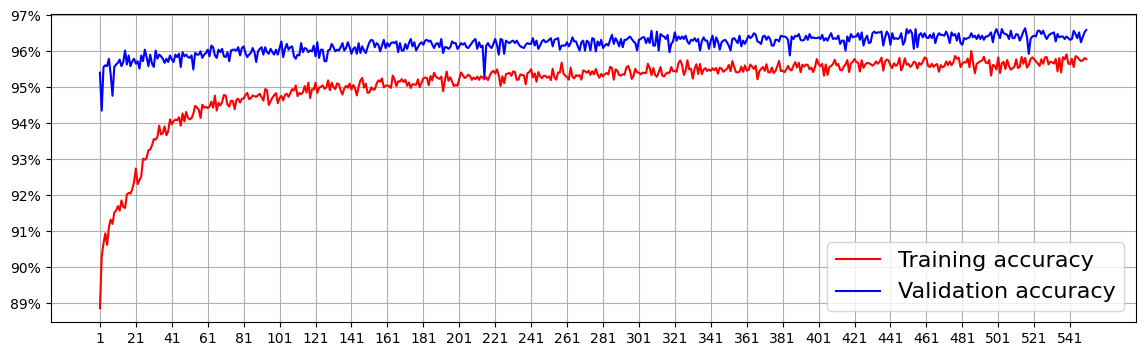

In [32]:
# accuracy chart
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4))
x = np.arange(0, epochs, 20)
plt.xticks(ticks=x, labels=x+1, rotation=0)
y = np.arange(0, 1.05, .01)
plt.yticks(ticks=y, labels=[f"{tk:.0%}" for tk in y])
plt.plot(train_history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(train_history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()

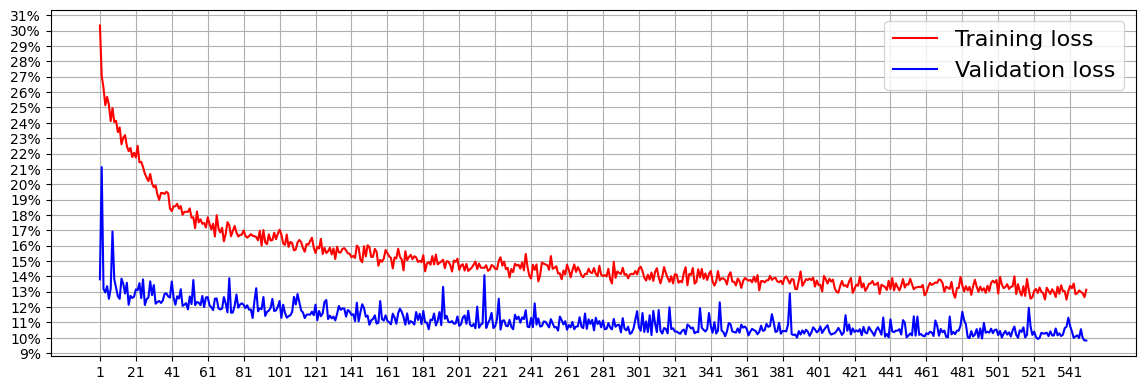

In [34]:
# loss chart
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 4.5))
x = np.arange(0, epochs, 20)
plt.xticks(ticks=x, labels=x+1, rotation=0)
y = np.arange(0, 1.05, .01)
plt.yticks(ticks=y, labels=[f"{tk:.0%}" for tk in y])
plt.plot(train_history.history['loss'], 'r', label='Training loss')
plt.plot(train_history.history['val_loss'], 'b', label='Validation loss')
plt.grid()
fig = plt.legend(prop={"size": 16})
plt.show()